In [1]:
# import cupy as cp
from all_functions import *
# from cuml.tsa.arima import ARIMA as cudaARIMA
# import cudf
from sklearn.metrics import mean_absolute_percentage_error as mape
from aeon.visualisation import plot_series

# Create seasonal data with a trend, a seasonal pattern and noise

# Fit a seasonal ARIMA model
# model = cudaARIMA(y,
#                order=(4,1,3),
#                seasonal_order=(2,1,2,12),
#                fit_intercept=False)
# model.fit()
# # Forecast
# fc = model.forecast(10)
# print(fc) 


In [27]:
window = 12
horizon = 12
derivado = "etanolhidratado"
estado = "SP"
series = read_series(f'../datasets/venda/mensal/uf/{derivado}/mensal_{estado.lower()}_{derivado}.csv')
train, test = train_test_stats(series, horizon)
#https://otexts.com/fpp3/classical-decomposition.html

In [42]:

import numpy as np
import pandas as pd
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from gluonts.torch.model.deepar import DeepAREstimator
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName
from gluonts.evaluation.backtest import make_evaluation_predictions
from tqdm.autonotebook import tqdm
from gluonts.evaluation import Evaluator
from typing import Dict


# train_dataset = ListDataset(
#     [{"start": train.index[0], "target": train.values}],
#     freq="M"
# )



# # Configuração do modelo DeepAR
# estimator = DeepAREstimator(
#     freq="M", 
#     prediction_length=12,  # horizonte de previsão
#     trainer=Trainer(epochs=10, batch_size=32, ctx=mx.cpu())
# )

freq = "M"

# Preparando o ListDataset sem características estáticas categóricas
train_ds = ListDataset([
    {
        FieldName.TARGET: train.values,
        FieldName.START: train.index[0]
    }
], freq=freq)

test_ds = ListDataset([
    {
        FieldName.TARGET: test.values,
        FieldName.START: test.index[0]
    }
], freq=freq)

estimator = DeepAREstimator(freq=freq,
                            # context length is number of time steps will look back(5 days in a week)
                            context_length=12,
                            prediction_length=12,
                            cardinality=[1],
                            num_layers=2,
                            dropout_rate=0.25,
                            trainer_kwargs={'max_epochs': 16}
                            )

# Treinando o modelo
predictor = estimator.train(train_ds, num_workers=4)

# Fazendo previsões
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds, predictor=predictor, num_samples=100
)


# # Avaliando o desempenho
# evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
# agg_metrics, item_metrics = evaluator(tss, forecasts)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



  | Name  | Type        | Params | In sizes                                                   | Out sizes   
------------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 23.3 K | [[1, 1], [1, 1], [1, 48, 2], [1, 48], [1, 48], [1, 12, 2]] | [1, 100, 12]
------------------------------------------------------------------------------------------------------------------
23.3 K    Trainable params
0         Non-trainable params
23.3 K    Total params
0.093     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'train_loss' reached 13.21413 (best 13.21413), saving model to '/exp/lucas/Statistics_and_Seq2Seq/lightning_logs/version_9/checkpoints/epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 12.60394 (best 12.60394), saving model to '/exp/lucas/Statistics_and_Seq2Seq/lightning_logs/version_9/checkpoints/epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 12.48780 (best 12.48780), saving model to '/exp/lucas/Statistics_and_Seq2Seq/lightning_logs/version_9/checkpoints/epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 12.46144 (best 12.46144), saving model to '/exp/lucas/Statistics_and_Seq2Seq/lightning_logs/version_9/checkpoints/epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 12.24156 (best 12.24156), saving model to '/exp/lucas/Statistics_and_Seq2Seq/lightning_logs/version_9/checkpoints/epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss

In [75]:
list(forecast_it)

[]

In [43]:
# print("Gathering time series conditioning values ...")
# tss = list(tqdm(ts_it, total=len(test.values)))
# print("Gathering time series predictions ...")
forecasts = list(tqdm(forecast_it, total=len(test.values)))



  0%|          | 0/12 [00:00<?, ?it/s]

In [59]:
for forecast in list(forecasts):
  print(forecast.samples)

[[ 3.77418582e-11  2.69809342e-10 -7.25645100e-11 ...  1.82749579e-11
  -1.34501424e-10  1.51250505e-11]
 [-4.52435069e-11 -3.41620378e-11 -5.36644652e-11 ...  5.61388852e-11
   1.01697616e-10  1.14323544e-10]
 [-9.79081261e-11 -4.27744992e-11 -1.85513035e-10 ... -1.51414450e-10
  -3.64894837e-10 -7.39826811e-11]
 ...
 [-7.14795887e-12  2.71771911e-11  6.03957370e-11 ... -1.07905629e-10
  -1.34290939e-10 -5.01647612e-11]
 [ 1.73444370e-10  2.35063670e-11  2.80541996e-11 ...  6.49707579e-11
   9.00117619e-11  3.24836720e-11]
 [ 6.98503130e-11 -3.82418715e-11  3.63507488e-11 ...  6.18254753e-11
  -1.12716746e-10  1.50341753e-10]]


In [63]:
forecast_list = [forecast.samples for forecast in list(forecasts)]

# # Exibindo resultados
# for i, (forecast) in enumerate(zip(forecast_list)):
#     print(f"Test Series {i + 1}:")
#     # print(f"Forecast samples (shape {forecast}):")
#     print(forecast)
#     print("\n")

forecast_list

[array([[ 3.77418582e-11,  2.69809342e-10, -7.25645100e-11, ...,
          1.82749579e-11, -1.34501424e-10,  1.51250505e-11],
        [-4.52435069e-11, -3.41620378e-11, -5.36644652e-11, ...,
          5.61388852e-11,  1.01697616e-10,  1.14323544e-10],
        [-9.79081261e-11, -4.27744992e-11, -1.85513035e-10, ...,
         -1.51414450e-10, -3.64894837e-10, -7.39826811e-11],
        ...,
        [-7.14795887e-12,  2.71771911e-11,  6.03957370e-11, ...,
         -1.07905629e-10, -1.34290939e-10, -5.01647612e-11],
        [ 1.73444370e-10,  2.35063670e-11,  2.80541996e-11, ...,
          6.49707579e-11,  9.00117619e-11,  3.24836720e-11],
        [ 6.98503130e-11, -3.82418715e-11,  3.63507488e-11, ...,
          6.18254753e-11, -1.12716746e-10,  1.50341753e-10]], dtype=float32)]

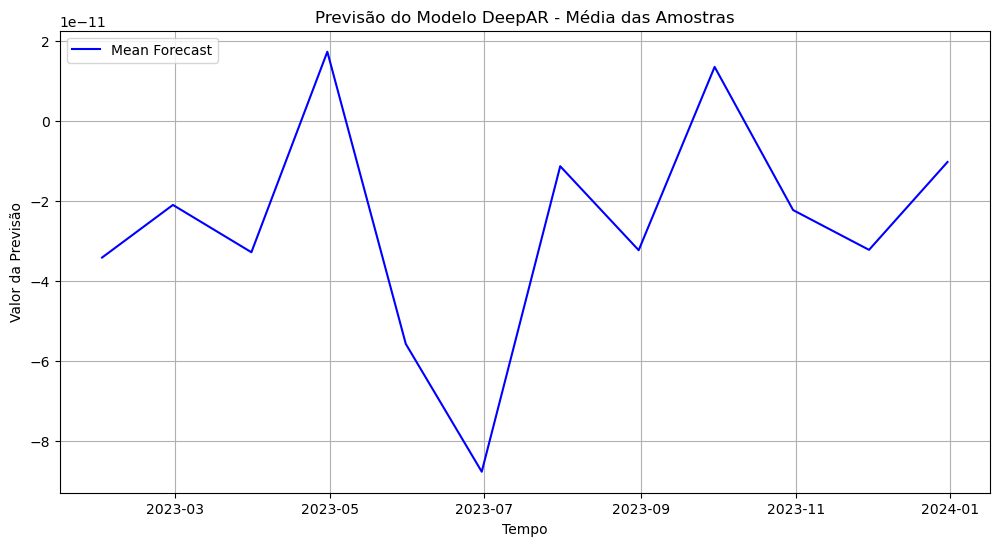

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Supondo que forecast_list contém uma lista de previsões
forecast_samples = forecast_list[0]  # Pegando a primeira previsão na lista

# Calcule a média das amostras para obter uma previsão única
mean_forecast = np.mean(forecast_samples, axis=0)

# Crie um índice de tempo para as previsões
start_date = pd.to_datetime("2023-01-01")  # Ajuste a data de início conforme necessário
prediction_length = len(mean_forecast)
time_index = pd.date_range(start=start_date, periods=prediction_length, freq='M')

# Converta a previsão média para um DataFrame
forecast_df = pd.DataFrame(mean_forecast, index=time_index, columns=['Mean Forecast'])

# Visualize a previsão
plt.figure(figsize=(12, 6))
plt.plot(forecast_df.index, forecast_df['Mean Forecast'], label='Mean Forecast', color='blue')
# plt.plot(test.values)
plt.title('Previsão do Modelo DeepAR - Média das Amostras')
plt.xlabel('Tempo')
plt.ylabel('Valor da Previsão')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='m3'>)

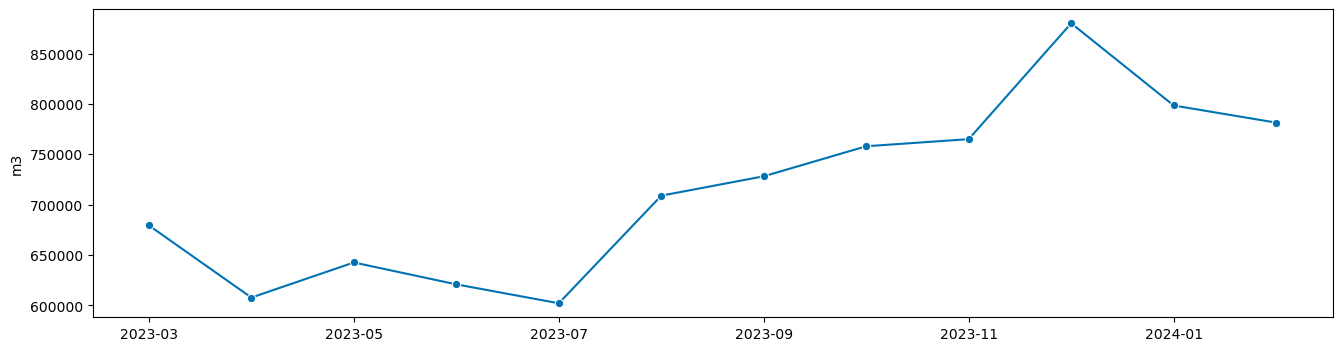

In [68]:
plot_series(test)

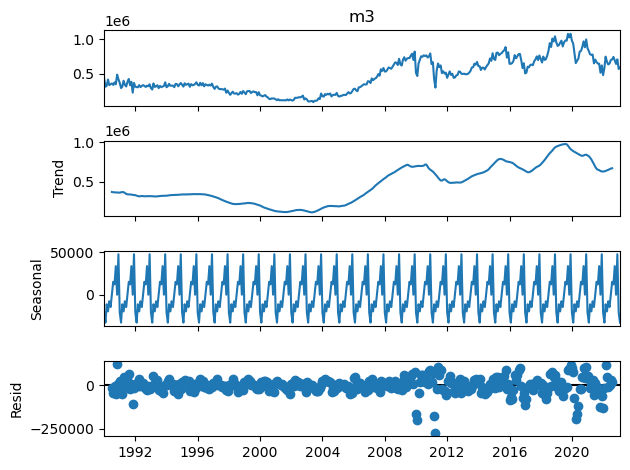

In [136]:
deco = plot_decompose(train, 'multiplicative')

In [137]:
data_period = pd.Series(deco.trend.values, index=train.index)
data_period

timestamp
1990-01   NaN
1990-02   NaN
1990-03   NaN
1990-04   NaN
1990-05   NaN
           ..
2022-10   NaN
2022-11   NaN
2022-12   NaN
2023-01   NaN
2023-02   NaN
Freq: M, Length: 398, dtype: float64

In [138]:
deco.resid

timestamp
1990-01-01   NaN
1990-02-01   NaN
1990-03-01   NaN
1990-04-01   NaN
1990-05-01   NaN
              ..
2022-10-01   NaN
2022-11-01   NaN
2022-12-01   NaN
2023-01-01   NaN
2023-02-01   NaN
Freq: MS, Name: resid, Length: 398, dtype: float64

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

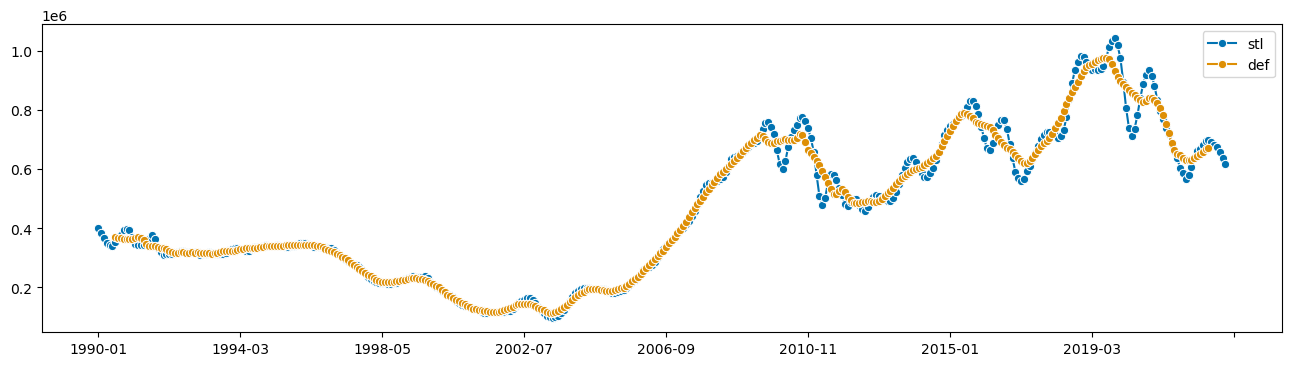

In [139]:
transformer = STLTransformer(sp=6, trend=7) 
stl = transformer.fit(train)
plot_series(stl.trend_, data_period, labels=["stl", "def"])
# plt.plot(deco.trend)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='m3'>)

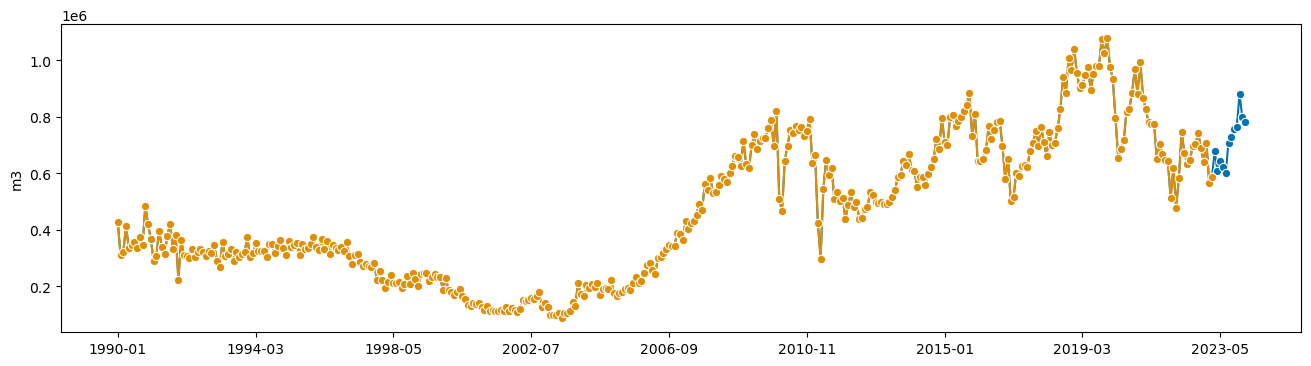

In [143]:
plot_series(series, train)

In [141]:
train_st = transform_train(train, format='log')
train_st.info()

<class 'pandas.core.series.Series'>
PeriodIndex: 398 entries, 1990-01 to 2023-02
Freq: M
Series name: None
Non-Null Count  Dtype  
--------------  -----  
398 non-null    float64
dtypes: float64(1)
memory usage: 6.2 KB


In [142]:
transform = ConditionalDeseasonalizer(sp=12, model="multiplicative",seasonality_test=)
transform.fit(train)
train_deseasonal = transform.transform(train)
train_deseasonal

SyntaxError: invalid syntax (1670257726.py, line 1)

In [ ]:
transform.seasonal_

1990-01    0.966860
1990-02    0.929937
1990-03    1.022318
1990-04    1.006375
1990-05    1.001083
1990-06    0.973489
1990-07    0.977209
1990-08    1.002573
1990-09    0.981594
1990-10    1.022909
1990-11    0.994652
1990-12    1.121000
Freq: M, Name: seasonal, dtype: float64

In [ ]:
train_tf = transform_regressors(train, 'deseasonal')
train_tf
# data = rolling_window(pd.concat([train_tf, pd.Series([0,0,0,0,0,0,0,0,0,0,0,0], index=test.index)]), window)
# # data = rolling_window_transform(series, window) #log
# data = data.dropna()
# X_train, X_test, y_train, _ = train_test_split(data, horizon)
# y_train

1990-01    437314.979806
1990-02    385761.118052
1990-03    281317.617233
1990-04    389022.625134
1990-05    360757.533155
               ...      
2022-10    867552.013610
2022-11    879073.578597
2022-12    958014.706598
2023-01    871143.095806
2023-02    928280.542052
Freq: M, Name: m3, Length: 398, dtype: float64

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='m3'>)

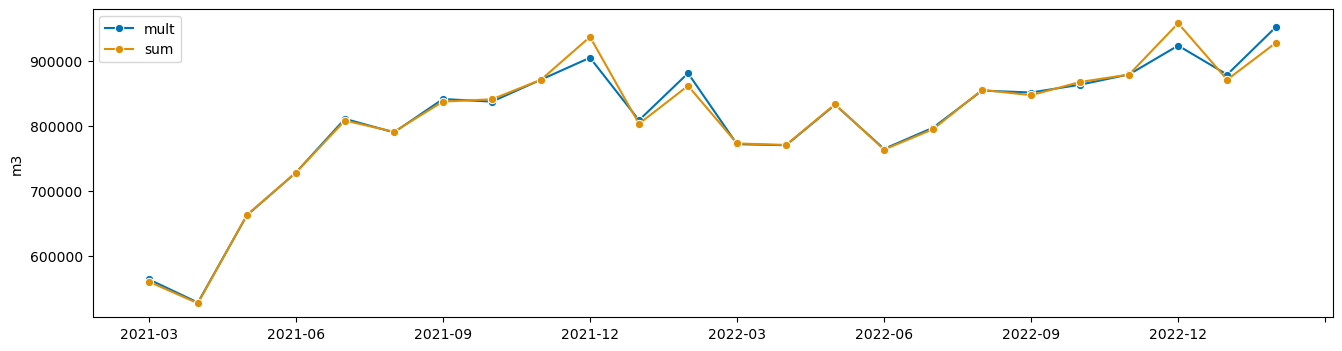

In [ ]:
plot_series(train_deseasonal[-24:], train_tf[-24:], labels=["mult", "sum"])